<center><h1>MEDICAL IMAGE SEGMENTATION USING CNN AND DP</h1></center>

<center><h3>Nilabjanayan Bera</h3></center>

<p style="font-size:15px">Under the guidence of :</p> 

<h2>Dr. Sujoy Kumar Biswas</h2>
<p style="font-size:15px">Director and Principal Scientist</p> 
<p style="font-size:15px">AIMP LABS, Kolkata</p>

<h4>Joint affiliation:</h4>
<p style="font-size:15px">Visiting Scientist</p>
<p style="font-size:15px">Electronics and Communication Sciences Unit (ECSU)</p>
<p style="font-size:15px">Indian Statistical Institute, Kolkata</p>
<p style="font-size:15px">Homepage: <a href="https://sujoykb.bitbucket.io/">This link</a> 

This project is about medical image segmentation using <b>Convolutional Neural Network</b>(CNN) and <b>Dynamic Programming</b>(DP).Applying Deep Learning methods will be really successful where plenty of data will be annotated. But here the problem is in medical image segmentation tasks usually we have very lesss no. of training data.To overcome that we have used <b>end-to-end learning of convolutional neural net and dynamic programming</b> method. This method was first introduced in this paper:<b><i>"End-to-end learning of convolutional neural net and dynamic programming for left ventricle segmentation"</i></b> by <b>Nhat M. Nguyen</b> and <b>Nilanjan Ray</b> and I will follow this.

In this project I shall explain how we can apply Dynamic Programming in image segmentation in combination with classical U-Net and I shall show two specific case study.

<h3><u>Case Study-I</u></h3>

<b>Problem:</b>Left ventricle segmentation from short axis MRI data.<br>
<b>Dataset:</b>Download the original ACDC dataset.Also you can download the preprocessed dataset hdf5 file from <a href="https://drive.google.com/open?id=1B7JC3WVSq1CcPJmYc3RGfhVFL12BWNKJ">this Google Drive link</a>and put it in "heart_data" folder.<br>
There are 1516 train images and 386 test images. we will take only 12 train images and will train the model with that little no. of train images.<br>
<b>Challange:</b>It is really hard to segment the left ventricle. Often the classical U-Net models can't completely seperate myocardium and right ventricle from the left ventricle.<br> 
For more info please visit <a href="https://github.com/Dion11235/Left_Ventricle_segmentation_using_EDPCNN">this github repository</a>.

<h3><u>Case Study-II</u></h3>

<b>Problem:</b>Rat embryo image segmentation from microscopic data.<br>
<b>Dataset:</b>Download the rat embryo dataset from <a href="https://bbbc.broadinstitute.org/BBBC003">this link</a>. Download this data and put it in "embryo_data" folder<br>
There are only 15 images in this dataset. We will take 12 of them as train images and 3 as test images.
<b>Challange:</b>It is not very easy to segment the embryo cell with classical methods. Often the classical U-Net models can't completely segment the cells of the embryo, instead they give the boundary of the zona pelucida.<br>

## Requirements:

1. Numpy
2. Pytorch >= 0.4
3. TensorboardX
4. Shapely
5. Matplotlib
6. Scipy
7. Scikit-image
8. Opencv for python
9. nibabel
10.h5py
11.Pandas

## How to run:

simply run the cells of ML_Proj.ipynb. you can edit the hyperparameters in the args Series cell.

## Note:

* This code only works on GPUs, preferrably NVIDIA ones with at least 10GB of VRAM. For GPUs with less VRAM, lowering the batch size may help.
* Due to the non-deterministic nature of large matrices reduction operations on GPU, the results over multiple runs will be slightly different but they usually have very similar loss curves and final performance.
* Sometime the training of the original U-Net may diverge and never go above 20% dice score on train set with only 10 images, simply restart the run script if this occurs.

## Importing Necessery Libraries

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import _pickle
import torch
import cv2
from our_train_edpcnn import main, make_batch_input, get_star_pattern_values, star_pattern_ind_to_mask, smooth_ind
from network import UNet
from snake.snake import SnakePytorch
%matplotlib inline

## Heart Dataset

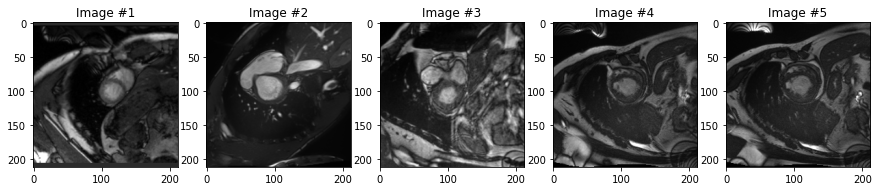

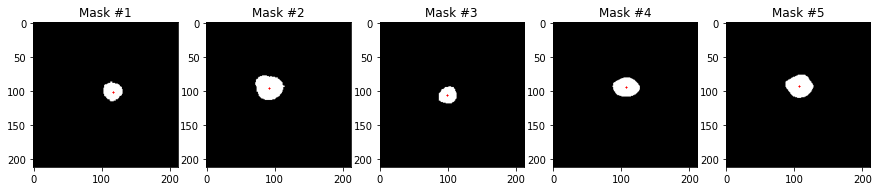

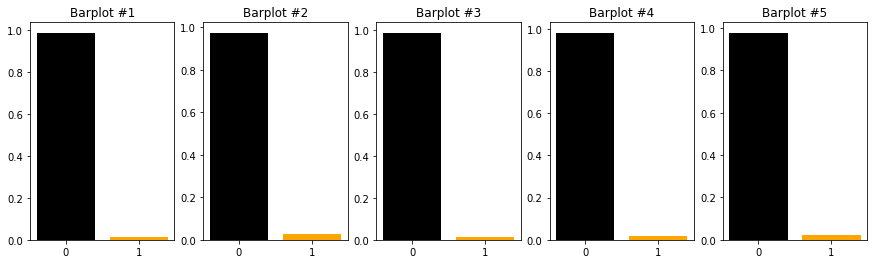

In [34]:
from data_iterator import Dataset

d = Dataset()

fig1 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
  img = d.train_set.images[j].squeeze()
  fig1.add_subplot(1, 5, j+1)
  plt.imshow(img, cmap=plt.cm.gray)
  plt.title('Image #{}'.format(j+1))
#plt.savefig("/content/drive/MyDrive/ML_Proj/EDPCNN-master/visualize.jpg")

fig2 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
  mask = d.train_set.masks[j]
  center = d.train_set.centers[j]
  fig2.add_subplot(1, 5, j+1)
  plt.imshow(mask, alpha=1.0, cmap=plt.cm.gray)
  plt.scatter(center[1], center[0], color="r", marker="x", s=1)
  plt.title('Mask #{}'.format(j+1))
#plt.savefig("/content/drive/MyDrive/ML_Proj/EDPCNN-master/visualize.jpg")

fig3 = plt.figure(figsize = (15,4))
for j in range(0,5,1):
  mask = d.train_set.masks[j]
  fig3.add_subplot(1, 5, j+1)
  mask0 = np.sum(mask == 0)/(mask.shape[0]*mask.shape[1])
  mask1 = 1 - mask0
  plt.bar([0,1],[mask0,mask1], color = ['black','orange'])
  plt.title('Barplot #{}'.format(j+1))
  plt.xticks([0,1],[0,1])
#plt.savefig("/content/drive/MyDrive/ML_Proj/EDPCNN-master/visualize.jpg")

plt.show()

## Embryo Dataset

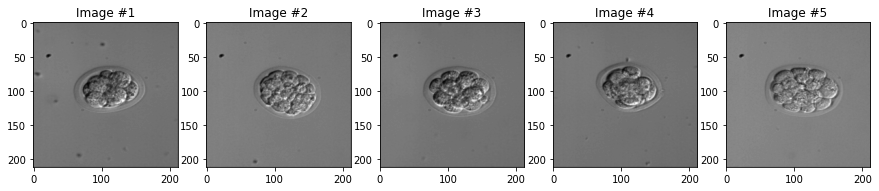

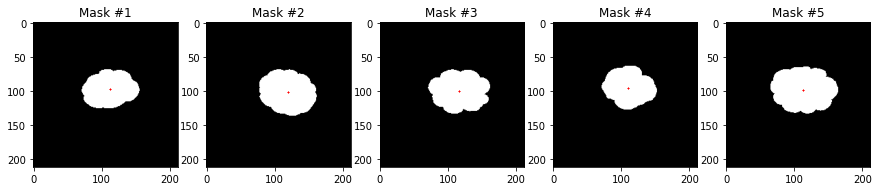

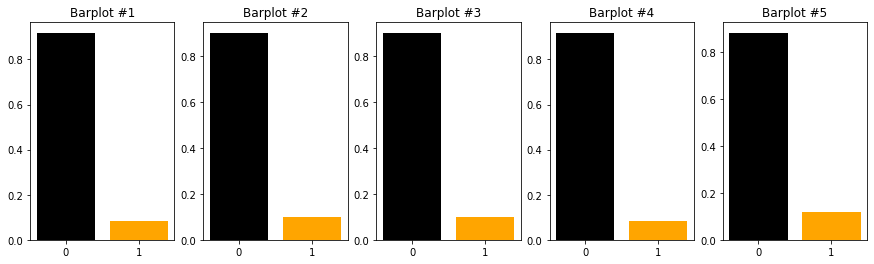

In [33]:
from our_data_iter import Dataset

d = Dataset()

fig1 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
  img = d.train_set.images[j].squeeze()
  fig1.add_subplot(1, 5, j+1)
  plt.imshow(img, cmap=plt.cm.gray)
  plt.title('Image #{}'.format(j+1))
#plt.savefig("/content/drive/MyDrive/ML_Proj/EDPCNN-master/visualize.jpg")

fig2 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
  mask = d.train_set.masks[j]
  center = d.train_set.centers[j]
  fig2.add_subplot(1, 5, j+1)
  plt.imshow(mask, alpha=1.0, cmap=plt.cm.gray)
  plt.scatter(center[1], center[0], color="r", marker="x", s=1)
  plt.title('Mask #{}'.format(j+1))
#plt.savefig("/content/drive/MyDrive/ML_Proj/EDPCNN-master/visualize.jpg")

fig3 = plt.figure(figsize = (15,4))
for j in range(0,5,1):
  mask = d.train_set.masks[j]
  fig3.add_subplot(1, 5, j+1)
  mask0 = np.sum(mask == 0)/(mask.shape[0]*mask.shape[1])
  mask1 = 1 - mask0
  plt.bar([0,1],[mask0,mask1], color = ['black','orange'])
  plt.title('Barplot #{}'.format(j+1))
  plt.xticks([0,1],[0,1])
#plt.savefig("/content/drive/MyDrive/ML_Proj/EDPCNN-master/visualize.jpg")

plt.show()

## Left Ventricle Segmentation Using U-Net

In [2]:
from our_train_unet import main as train_unet

args1 = pd.Series({'seed': 0,
                 'lr': 1e-4,
                 'n_epochs': 500,
                 'weight_decay': 0.0,
                 'batch_sz': 10,
                 'log_freq': 50,
                 'train_eval_freq': 50,
                 'val_eval_freq': 50,
                 'train_set_sz': 12,
                 'num_cls': 1,
                 'log_dir': 'log/unet-1_cls/ours',
                 'load_pretrained':0,
                 'use_ce': 1})

In [3]:
out1 = train_unet(args1)

/usr/local/lib/python3.8/dist-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer
/home/sysadm/Dipan/LV_Seg/EDPCNN-master-20210621T060724Z-001/EDPCNN-master/network.py:11: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight)
/home/sysadm/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/sysadm/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.s

......................epoch :  1
......................epoch :  2
......................epoch :  3
......................epoch :  4
......................epoch :  5
......................epoch :  6
......................epoch :  7
......................epoch :  8
......................epoch :  9
......................epoch :  10
......................epoch :  11
......................epoch :  12
......................epoch :  13
......................epoch :  14
......................epoch :  15
......................epoch :  16
......................epoch :  17
......................epoch :  18
......................epoch :  19
......................epoch :  20
......................epoch :  21
......................epoch :  22
......................epoch :  23
......................epoch :  24

step=50	epoch=25	iter=2	loss=0.049512509256601334
step=50	epoch=25	iter=2	train_eval: train_dice=0.8599628806114197
step=50	epoch=25	iter=2	valid_dice=0.6051241755485535
better val dice detect

step=400	epoch=200	iter=2	train_eval: train_dice=0.9843764305114746
step=400	epoch=200	iter=2	valid_dice=0.6432352066040039
......................epoch :  200
......................epoch :  201
......................epoch :  202
......................epoch :  203
......................epoch :  204
......................epoch :  205
......................epoch :  206
......................epoch :  207
......................epoch :  208
......................epoch :  209
......................epoch :  210
......................epoch :  211
......................epoch :  212
......................epoch :  213
......................epoch :  214
......................epoch :  215
......................epoch :  216
......................epoch :  217
......................epoch :  218
......................epoch :  219
......................epoch :  220
......................epoch :  221
......................epoch :  222
......................epoch :  223
......................epoch :  224



......................epoch :  398
......................epoch :  399

step=800	epoch=400	iter=2	loss=0.0010746996849775314
step=800	epoch=400	iter=2	train_eval: train_dice=1.0
step=800	epoch=400	iter=2	valid_dice=0.637707531452179
......................epoch :  400
......................epoch :  401
......................epoch :  402
......................epoch :  403
......................epoch :  404
......................epoch :  405
......................epoch :  406
......................epoch :  407
......................epoch :  408
......................epoch :  409
......................epoch :  410
......................epoch :  411
......................epoch :  412
......................epoch :  413
......................epoch :  414
......................epoch :  415
......................epoch :  416
......................epoch :  417
......................epoch :  418
......................epoch :  419
......................epoch :  420
......................epoch :  42

<h3>Training Loss</h3>

Text(0.5, 1.0, 'Training Loss Curve')

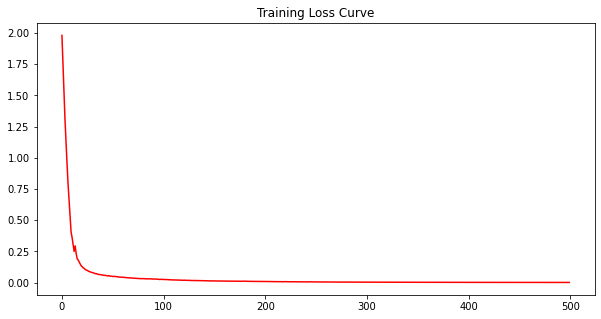

In [8]:
plt.figure(figsize = (10,5))
plt.plot(out1[2],'r')
plt.title("Training Loss Curve")

<h3>Dice Score</h3>

Text(0.5, 1.0, 'Dice Scores')

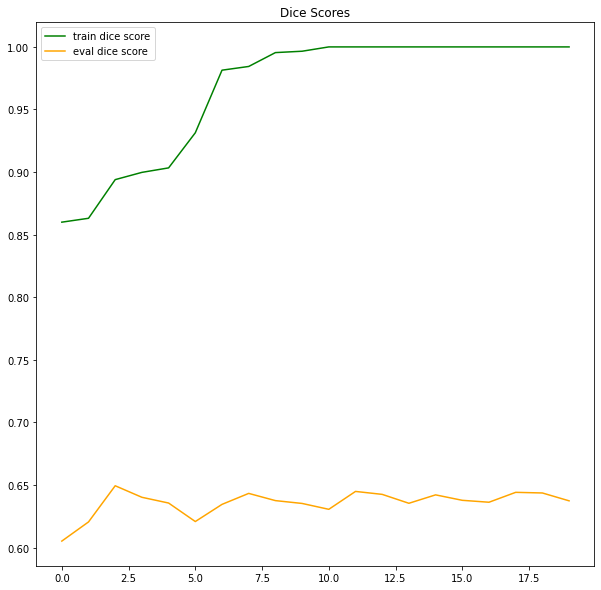

In [10]:
plt.figure(figsize = (10,10))
plt.plot(out1[3],'green')
plt.plot(out1[4],'orange')
plt.legend(['train dice score','eval dice score'])
plt.title("Dice Scores")

<h3>Testing and Visualization</h3>

In [20]:
model_path = "log/unet-1_cls/ours"
net = UNet(in_dim=1, out_dim=2).cuda()
ckpt_path = os.path.join(model_path, 'best_model.pth.tar')
net.load_state_dict(_pickle.load(open(ckpt_path, 'rb')))

<All keys matched successfully>

In [21]:
from data_iterator import Dataset
import torch.nn.functional as F

d = Dataset()
imgs = d.test_set.images           
batch_sz = 10
num_classes = 2

l_pred =[]

net.eval()
with torch.no_grad():
    data_sz = len(imgs)
    n_batches = int(np.ceil(data_sz / batch_sz))
    dice_scores = []
    for j in range(n_batches):
        start = j * batch_sz
        end = (j + 1) * batch_sz
        imgs_batch = imgs[start:end]
        imgs_batch = make_batch_input(imgs_batch)
        imgs_batch = torch.cuda.FloatTensor(imgs_batch)
        logits = net(imgs_batch)
        softmax = F.softmax(logits, dim=1)
        pred_class = torch.argmax(softmax, dim=1)
        for i in range(len(pred_class)):
            pred = pred_class[i].cpu().numpy()
            l_pred.append(pred)

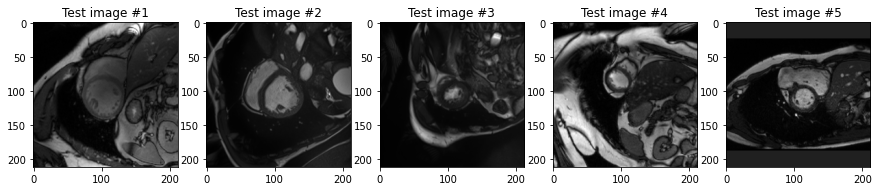

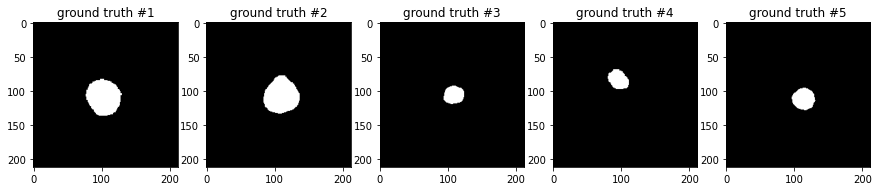

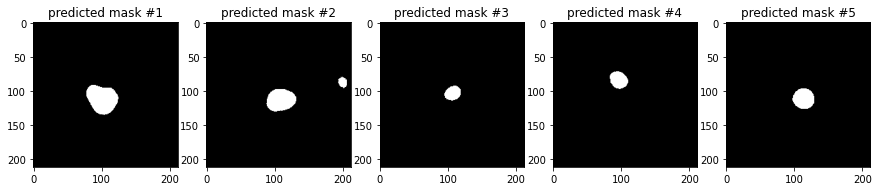

In [22]:
# Visualizing the test data set

import matplotlib.pyplot as plt
from skimage.io import imread

d = Dataset()
test = d.test_set

fig1 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
    img = test.images[j].squeeze()
    fig1.add_subplot(1, 5, j+1)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title("Test image #{}".format(j+1))

#plt.savefig("visualize/test_images.jpg")

fig2 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
    mask = test.masks[j]
    fig2.add_subplot(1, 5, j+1)
    plt.imshow(mask, alpha=1.0, cmap=plt.cm.gray)
    plt.title('ground truth #{}'.format(j+1))

#plt.savefig("visualize/test_masks.jpg")

fig3 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
    pred_mask = l_pred[j]
    fig3.add_subplot(1, 5, j+1)
    plt.imshow(pred_mask, alpha=1.0, cmap=plt.cm.gray)
    plt.title("predicted mask #{}".format(j+1))

#plt.savefig("visualize/predicted_masks.jpg")    
   
plt.show()

In [ ]:
## If you want to save these images:

from PIL import Image

for i,img in enumerate(l_pred):
    im = Image.fromarray((l_pred[i] * 255).astype(np.uint8))
    im.save("LV_predictions/pred_mask_UNet{:03d}".format(i)+".jpg")

## Left Ventricle Segmentation Using EDPCNN

In [25]:
args2 = pd.Series({'train_set_sz' : 12,
                  'lr' : 1e-4,
                  'delta' : 2,
                  'batch_sz' : 10,
                  'log_freq' : 50,
                  'num_lines' : 50,
                  'radius' : 65,
                  'snake_batch_sz' : 100,
                  'train_eval_freq' : 50,
                  'val_eval_freq' : 50,
                  'sigma_scaling' : 200,
                  'gs_decay' : 0.00,
                  'n_epochs' : 500,
                  'smoothing_window' : 5,
                  'dice_approx_train_steps' : 10,
                  'num_samples' : 10,
                  'use_center_jitter' : True,
                  'theta_jitter' : np.pi,
                  'log_dir' : os.path.join("log/edpcnn/train_set_sz=10,delta=2,smooth=5,nl=50,theta_jitter=pi"),
                  'seed':0,
                  'weight_decay' : 0.0,
                  'ckpt': '',
                  'sigma': 1.0
                  
                 })

In [28]:
out2 = main(args2)

/home/sysadm/Dipan/LV_Seg/EDPCNN-master-20210621T060724Z-001/data_2D_size_212_212_res_1.36719_1.36719.hdf5
Keys in dataset:  ['cardiac_phase_test', 'cardiac_phase_train', 'diagnosis_test', 'diagnosis_train', 'height_test', 'height_train', 'images_test', 'images_train', 'masks_test', 'masks_train', 'patient_id_test', 'patient_id_train', 'weight_test', 'weight_train']


/home/sysadm/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/sysadm/.local/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


...................... epoch :  1
...................... epoch :  2
...................... epoch :  3
...................... epoch :  4
...................... epoch :  5
...................... epoch :  6
...................... epoch :  7
...................... epoch :  8
...................... epoch :  9
...................... epoch :  10
...................... epoch :  11
...................... epoch :  12
...................... epoch :  13
...................... epoch :  14
...................... epoch :  15
...................... epoch :  16
...................... epoch :  17
...................... epoch :  18
...................... epoch :  19
...................... epoch :  20
...................... epoch :  21
...................... epoch :  22
...................... epoch :  23
...................... epoch :  24

step=50	epoch=25	iter=2	loss=4.545354843139648	snake_approx_train_loss=2.1590492725372314	nll_approx_loss=2.386305332183838	lr=0.001	time=38.26853638800094
step=50	epoc

...................... epoch :  176
...................... epoch :  177
...................... epoch :  178
...................... epoch :  179
...................... epoch :  180
...................... epoch :  181
...................... epoch :  182
...................... epoch :  183
...................... epoch :  184
...................... epoch :  185
...................... epoch :  186
...................... epoch :  187
...................... epoch :  188
...................... epoch :  189
...................... epoch :  190
...................... epoch :  191
...................... epoch :  192
...................... epoch :  193
...................... epoch :  194
...................... epoch :  195
...................... epoch :  196
...................... epoch :  197
...................... epoch :  198
...................... epoch :  199

step=400	epoch=200	iter=2	loss=2.2230021953582764	snake_approx_train_loss=1.0918934345245361	nll_approx_loss=1.1311087608337402	lr=0.00

step=700	epoch=350	iter=2	valid_dice=0.8533533811569214
...................... epoch :  350
...................... epoch :  351
...................... epoch :  352
...................... epoch :  353
...................... epoch :  354
...................... epoch :  355
...................... epoch :  356
...................... epoch :  357
...................... epoch :  358
...................... epoch :  359
...................... epoch :  360
...................... epoch :  361
...................... epoch :  362
...................... epoch :  363
...................... epoch :  364
...................... epoch :  365
...................... epoch :  366
...................... epoch :  367
...................... epoch :  368
...................... epoch :  369
...................... epoch :  370
...................... epoch :  371
...................... epoch :  372
...................... epoch :  373
...................... epoch :  374

step=750	epoch=375	iter=2	loss=2.9034738540

<h3>Loss Curves</h3>

Text(0.5, 1.0, 'NLL loss')

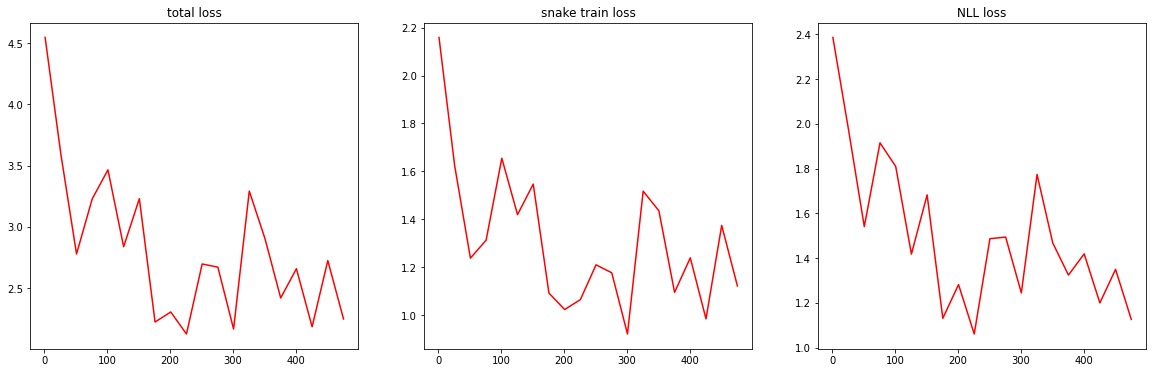

In [50]:
plt.figure(figsize = (20,6))

plt.subplot(131)
plt.plot(np.arange(1,501,25),out2[1],'-r')
plt.title("total loss")

plt.subplot(132)
plt.plot(np.arange(1,501,25),out2[2],'-r')
plt.title("snake train loss")

plt.subplot(133)
plt.plot(np.arange(1,501,25),out2[3],'-r')
plt.title("NLL loss")

#plt.savefig("visualize/edpcnn/losses.jpg")

<h3>Dice Scores</h3>

Text(0.5, 1.0, 'Dice Score Comparison')

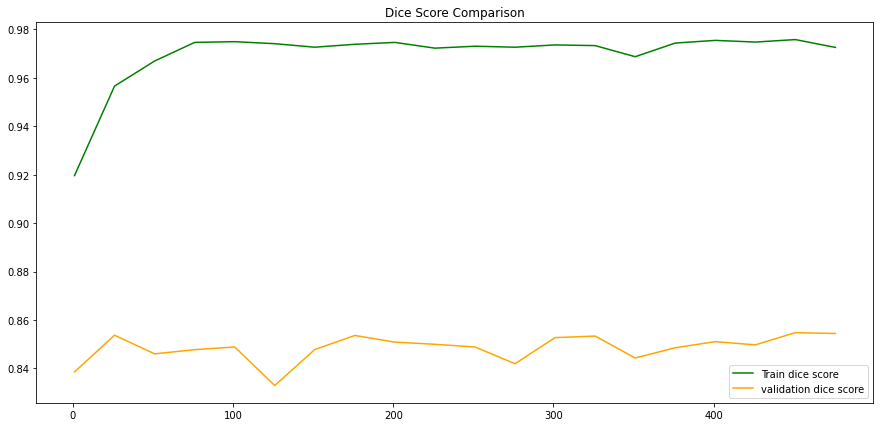

In [51]:
plt.figure(figsize = (15,7))
plt.plot(np.arange(1,501,25),out2[4],color = 'green')
plt.plot(np.arange(1,501,25),out2[5],color = 'orange')
plt.legend(["Train dice score", "validation dice score"])
plt.title("Dice Score Comparison")

#plt.savefig("visualize/edpcnn/dices10.jpg")

<h3>Testing and Visualization</h3>

In [23]:
model_path = "log/edpcnn/train_set_sz=10,delta=2,smooth=5,nl=50,theta_jitter=pi"
net = UNet(in_dim=1, out_dim=4).cuda()
ckpt_path = os.path.join(model_path, 'best_model.pth.tar')
net.load_state_dict(_pickle.load(open(ckpt_path, 'rb'))[0])

<All keys matched successfully>

In [26]:
d = Dataset()
imgs = d.test_set.images
centers = d.test_set.centers
batch_sz = args2.batch_sz
num_lines = args2.num_lines
radius = args2.radius
smoothing_window=args2.smoothing_window

snake_eval = SnakePytorch(args2.delta, args2.batch_sz, args2.num_lines, args2.radius)

l_pred = []

net.eval()
H, W = imgs.shape[-2:]
if smoothing_window is None:
    smoothing_window = num_lines // 4
with torch.no_grad():
    data_sz = len(imgs)
    n_batches = int(np.ceil(data_sz / batch_sz))
    dice_scores = []
    gs_fixed_shape = torch.zeros(snake_eval.b_sz, num_lines, radius).cuda()
    for j in range(n_batches):
        start = j * batch_sz
        end = (j + 1) * batch_sz
        imgs_batch = imgs[start:end]
        centers_batch = centers[start:end]
        batch_input = make_batch_input(imgs_batch)
        batch_input = torch.cuda.FloatTensor(batch_input)

        gs_logits = net(batch_input)[:, 3, ...]

        # get pixel values on the star pattern
        gs_logits, _, _ = get_star_pattern_values(gs_logits, None, centers_batch, num_lines, radius + 1)
        gs = gs_logits[:, :, 1:] - gs_logits[:, :, :-1]

        # run DP algo
        # can only put batch with fixed shape into the snake algorithm
        gs_fixed_shape.fill_(0)
        gs_fixed_shape[:len(gs), ...] = gs
        ind_sets = snake_eval(gs_fixed_shape).data.cpu().numpy()
        ind_sets = ind_sets[:len(gs), ...]
        ind_sets = np.expand_dims(smooth_ind(ind_sets.squeeze(-1), smoothing_window), -1)
        pred_masks = star_pattern_ind_to_mask(ind_sets, centers_batch, H, W, num_lines, radius)
        for i in range(len(pred_masks)):
            l_pred.append(pred_masks[i].squeeze())

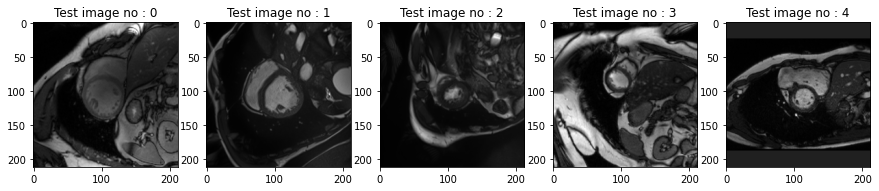

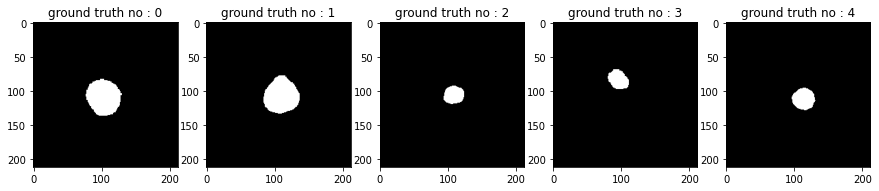

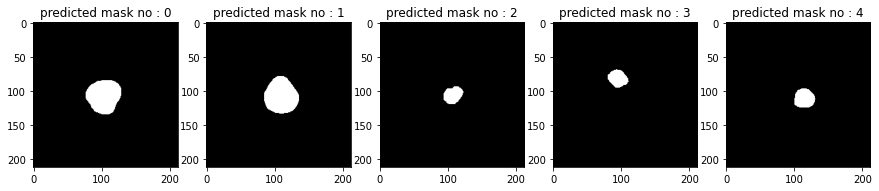

In [36]:
# Visualizing the test data set

import matplotlib.pyplot as plt

fig1 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
    img = valid.images[j].squeeze()
    fig1.add_subplot(1, 5, j+1)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title("Test image no : "+str(j))

#plt.savefig("visualize/edpcnn/test_images.jpg")

fig2 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
    mask = valid.masks[j]
    fig2.add_subplot(1, 5, j+1)
    plt.imshow(mask, alpha=1.0, cmap=plt.cm.gray)
    plt.title('ground truth no : '+str(j))

#plt.savefig("visualize/edpcnn/test_masks.jpg")

fig3 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
    pred_mask = l_pred[j]
    fig3.add_subplot(1, 5, j+1)
    plt.imshow(pred_mask, alpha=1.0, cmap=plt.cm.gray)
    plt.title("predicted mask no : "+str(j))

#plt.savefig("visualize/edpcnn/predicted_masks.jpg")    
    
plt.show()

In [18]:
## If you want to save these images:

from PIL import Image

for i,img in enumerate(l_pred):
    im = Image.fromarray((l_pred[i] * 255).astype(np.uint8))
    im.save("LV_predictions/pred_mask_EDPCNN{:03d}".format(i)+".jpg")

## Rat Embryo Segmentation

In [11]:
from our_train_unet_embryo import main

args3 = pd.Series({'seed': 0,
                 'lr': 1e-4,
                 'n_epochs': 500,
                 'weight_decay': 0.0,
                 'batch_sz': 5,
                 'log_freq': 10,
                 'train_eval_freq': 10,
                 'val_eval_freq': 10,
                 'train_set_sz': 12,
                 'num_cls': 1,
                 'log_dir': 'log/unet-1_cls/embryo',
                 'load_pretrained':0,
                 'use_ce': 1})

/home/sysadm/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [12]:
out3 = main(args3)

/home/sysadm/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:293: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  plugin_module = __import__('skimage.io._plugins.' + modname,


......................epoch :  1
......................epoch :  2
......................epoch :  3

step=10	epoch=4	iter=1	loss=0.2254476398229599
step=10	epoch=4	iter=1	train_eval: train_dice=0.8368093967437744
step=10	epoch=4	iter=1	valid_dice=0.815545916557312
better val dice detected.
......................epoch :  4
......................epoch :  5
......................epoch :  6

step=20	epoch=7	iter=2	loss=0.07789208739995956
step=20	epoch=7	iter=2	train_eval: train_dice=0.9722415804862976
step=20	epoch=7	iter=2	valid_dice=0.9632954597473145
better val dice detected.
......................epoch :  7
......................epoch :  8
......................epoch :  9

step=30	epoch=10	iter=3	loss=0.04944251850247383
step=30	epoch=10	iter=3	train_eval: train_dice=0.9639579057693481
step=30	epoch=10	iter=3	valid_dice=0.9514733552932739
......................epoch :  10
......................epoch :  11
......................epoch :  12
......................epoch :  13

step=40	epoc

......................epoch :  94
......................epoch :  95
......................epoch :  96

step=290	epoch=97	iter=2	loss=0.0033849221654236317
step=290	epoch=97	iter=2	train_eval: train_dice=0.9999799728393555
step=290	epoch=97	iter=2	valid_dice=0.9804458618164062
......................epoch :  97
......................epoch :  98
......................epoch :  99

step=300	epoch=100	iter=3	loss=0.0031160200014710426
step=300	epoch=100	iter=3	train_eval: train_dice=0.9998835921287537
step=300	epoch=100	iter=3	valid_dice=0.9813113212585449
......................epoch :  100
......................epoch :  101
......................epoch :  102
......................epoch :  103

step=310	epoch=104	iter=1	loss=0.003043578704819083
step=310	epoch=104	iter=1	train_eval: train_dice=0.9996504783630371
step=310	epoch=104	iter=1	valid_dice=0.9809144735336304
......................epoch :  104
......................epoch :  105
......................epoch :  106

step=320	epoch=107	i

......................epoch :  191
......................epoch :  192
......................epoch :  193

step=580	epoch=194	iter=1	loss=0.0009630527347326279
step=580	epoch=194	iter=1	train_eval: train_dice=1.0
step=580	epoch=194	iter=1	valid_dice=0.9814583659172058
......................epoch :  194
......................epoch :  195
......................epoch :  196

step=590	epoch=197	iter=2	loss=0.0009285276755690575
step=590	epoch=197	iter=2	train_eval: train_dice=1.0
step=590	epoch=197	iter=2	valid_dice=0.9814027547836304
......................epoch :  197
......................epoch :  198
......................epoch :  199

step=600	epoch=200	iter=3	loss=0.0009246600093320012
step=600	epoch=200	iter=3	train_eval: train_dice=1.0
step=600	epoch=200	iter=3	valid_dice=0.981513261795044
......................epoch :  200
......................epoch :  201
......................epoch :  202
......................epoch :  203

step=610	epoch=204	iter=1	loss=0.0008443058468401432
ste

......................epoch :  288
......................epoch :  289

step=870	epoch=290	iter=3	loss=0.0004624613793566823
step=870	epoch=290	iter=3	train_eval: train_dice=1.0
step=870	epoch=290	iter=3	valid_dice=0.9815220832824707
......................epoch :  290
......................epoch :  291
......................epoch :  292
......................epoch :  293

step=880	epoch=294	iter=1	loss=0.0004065875255037099
step=880	epoch=294	iter=1	train_eval: train_dice=1.0
step=880	epoch=294	iter=1	valid_dice=0.9817218780517578
......................epoch :  294
......................epoch :  295
......................epoch :  296

step=890	epoch=297	iter=2	loss=0.0004345819470472634
step=890	epoch=297	iter=2	train_eval: train_dice=1.0
step=890	epoch=297	iter=2	valid_dice=0.9817742705345154
......................epoch :  297
......................epoch :  298
......................epoch :  299

step=900	epoch=300	iter=3	loss=0.00041439998312853277
step=900	epoch=300	iter=3	train_eval

......................epoch :  386

step=1160	epoch=387	iter=2	loss=0.0002403914841124788
step=1160	epoch=387	iter=2	train_eval: train_dice=1.0
step=1160	epoch=387	iter=2	valid_dice=0.981195330619812
......................epoch :  387
......................epoch :  388
......................epoch :  389

step=1170	epoch=390	iter=3	loss=0.0002446805010549724
step=1170	epoch=390	iter=3	train_eval: train_dice=1.0
step=1170	epoch=390	iter=3	valid_dice=0.9816104769706726
......................epoch :  390
......................epoch :  391
......................epoch :  392
......................epoch :  393

step=1180	epoch=394	iter=1	loss=0.00024095983826555312
step=1180	epoch=394	iter=1	train_eval: train_dice=1.0
step=1180	epoch=394	iter=1	valid_dice=0.9815613627433777
......................epoch :  394
......................epoch :  395
......................epoch :  396

step=1190	epoch=397	iter=2	loss=0.00023523258278146386
step=1190	epoch=397	iter=2	train_eval: train_dice=1.0
step=11

......................epoch :  482
......................epoch :  483

step=1450	epoch=484	iter=1	loss=0.0001605860743438825
step=1450	epoch=484	iter=1	train_eval: train_dice=1.0
step=1450	epoch=484	iter=1	valid_dice=0.9815165996551514
......................epoch :  484
......................epoch :  485
......................epoch :  486

step=1460	epoch=487	iter=2	loss=0.00015887375047896057
step=1460	epoch=487	iter=2	train_eval: train_dice=1.0
step=1460	epoch=487	iter=2	valid_dice=0.9815157651901245
......................epoch :  487
......................epoch :  488
......................epoch :  489

step=1470	epoch=490	iter=3	loss=0.00016611906175967306
step=1470	epoch=490	iter=3	train_eval: train_dice=1.0
step=1470	epoch=490	iter=3	valid_dice=0.9814215898513794
......................epoch :  490
......................epoch :  491
......................epoch :  492
......................epoch :  493

step=1480	epoch=494	iter=1	loss=0.00015515429549850523
step=1480	epoch=494	iter

<h3>Loss Curves</h3>

Text(0.5, 1.0, 'Training Loss Curve')

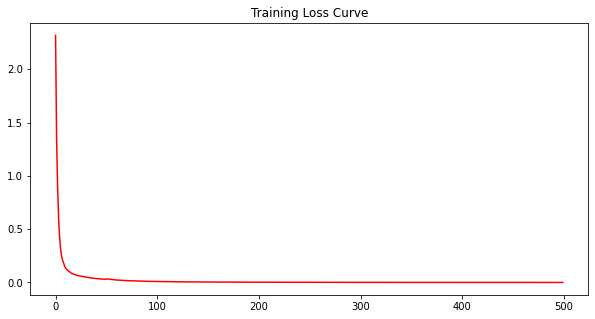

In [15]:
plt.figure(figsize = (10,5))
plt.plot(out3[2],'r')
plt.title("Training Loss Curve")

<h3>Dice Scores</h3>

Text(0.5, 1.0, 'Dice Scores')

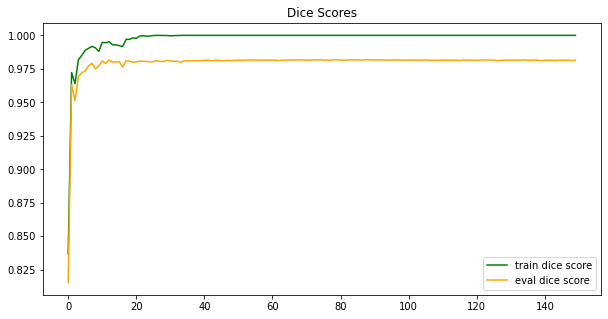

In [16]:
plt.figure(figsize = (10,5))
plt.plot(out3[3],'green')
plt.plot(out3[4],'orange')
plt.legend(['train dice score','eval dice score'])
plt.title("Dice Scores")

<h3>Testing and Visualization</h3>

In [5]:
model_path = 'log/unet-1_cls/embryo'
net = UNet(in_dim=1, out_dim=2).cuda()
ckpt_path = os.path.join(model_path, 'best_model.pth.tar')
net.load_state_dict(_pickle.load(open(ckpt_path, 'rb')))

<All keys matched successfully>

In [13]:
from our_data_iter import Dataset
import torch.nn.functional as F

d = Dataset()
imgs = d.test_set.images           
batch_sz = 5
num_classes = 2

l_pred =[]

net.eval()
with torch.no_grad():
    data_sz = len(imgs)
    n_batches = int(np.ceil(data_sz / batch_sz))
    dice_scores = []
    for j in range(n_batches):
        start = j * batch_sz
        end = (j + 1) * batch_sz
        imgs_batch = imgs[start:end]
        imgs_batch = make_batch_input(imgs_batch)
        imgs_batch = torch.cuda.FloatTensor(imgs_batch)
        logits = net(imgs_batch)
        softmax = F.softmax(logits, dim=1)
        pred_class = torch.argmax(softmax, dim=1)
        for i in range(len(pred_class)):
            pred = pred_class[i].cpu().numpy()
            l_pred.append(pred)

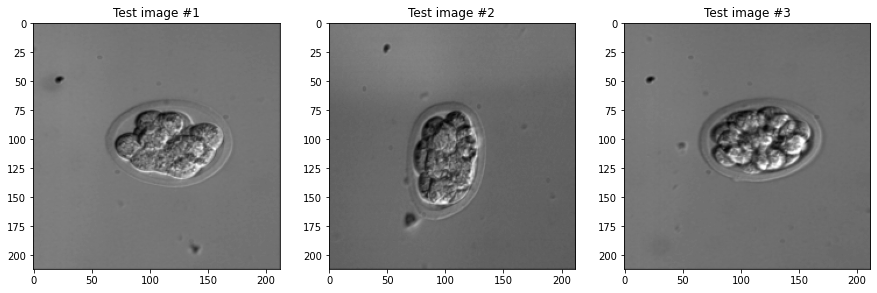

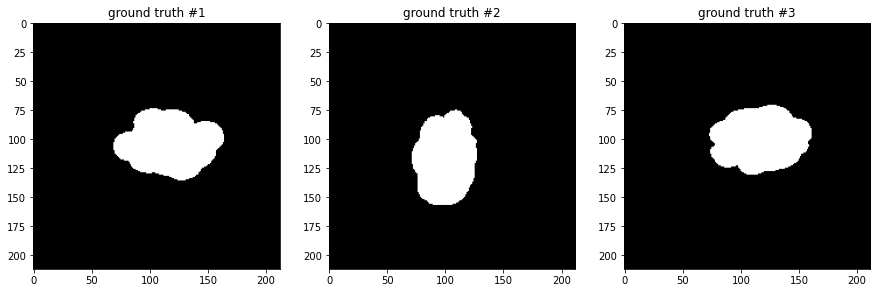

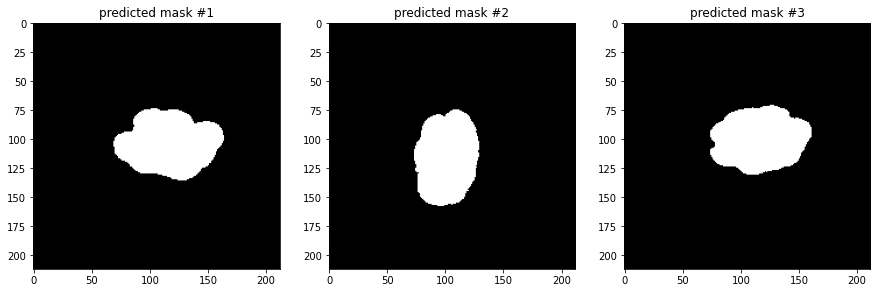

In [16]:
# Visualizing the test data set

import matplotlib.pyplot as plt
from skimage.io import imread

d = Dataset()
test = d.test_set

fig1 = plt.figure(figsize = (15,15))
for j in range(0,3,1):
    img = test.images[j].squeeze()
    fig1.add_subplot(1, 3, j+1)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title("Test image #{}".format(j+1))

#plt.savefig("visualize/test_images.jpg")

fig2 = plt.figure(figsize = (15,15))
for j in range(0,3,1):
    mask = test.masks[j]
    fig2.add_subplot(1, 3, j+1)
    plt.imshow(mask, alpha=1.0, cmap=plt.cm.gray)
    plt.title('ground truth #{}'.format(j+1))

#plt.savefig("visualize/test_masks.jpg")

fig3 = plt.figure(figsize = (15,15))
for j in range(0,3,1):
    pred_mask = l_pred[j]
    fig3.add_subplot(1, 3, j+1)
    plt.imshow(pred_mask, alpha=1.0, cmap=plt.cm.gray)
    plt.title("predicted mask #{}".format(j+1))

#plt.savefig("visualize/predicted_masks.jpg")    
   
plt.show()